<a href="https://colab.research.google.com/github/KatieHeller/Jailbreak-Classifier/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, accuracy_score, recall_score, f1_score
import os
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
import pickle
from sklearn.model_selection import GridSearchCV

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Fall 2024/SML 312/Final Project/data'

train_df = pd.read_csv(file_path + '/train.csv')
val_df = pd.read_csv(file_path + '/val.csv')

Mounted at /content/drive


In [ ]:
# Load precomputed features from FeatureEngineering.ipynb

tfidf_train = np.load(file_path + '/tfidf_train.npy')
tfidf_val = np.load(file_path + '/tfidf_val.npy')

tfidf_feature_names = np.load(file_path + '/tfidf_feature_names.npy', allow_pickle=True)

word2vec_train = np.load(file_path + '/word2vec_train.npy')
word2vec_val = np.load(file_path + '/word2vec_val.npy')

word2vec_smote_tomek_embeddings = np.load(file_path + '/word2vec_smote_tomek_embeddings.npy')
word2vec_smote_tomek_labels = np.load(file_path + '/word2vec_smote_tomek_labels.npy')

lda_train = pd.read_pickle(file_path + '/lda_train.pkl')
lda_val = pd.read_pickle(file_path + '/lda_val.pkl')

with open(file_path + '/lda_topics.pkl', 'rb') as f:
  lda_topics = pickle.load(f)

In [ ]:
word2vec_feature_names = [f"embedding_{i+1}" for i in range(word2vec_train.shape[1])]

lda_feature_names = [f"topic_{i+1}" for i in range(lda_train.shape[1])]

In [ ]:
train_df['clean_prompt'] = train_df['clean_prompt'].fillna('')
val_df['clean_prompt'] = val_df['clean_prompt'].fillna('')

In [ ]:
# Function for viewing evaluation metrics

def evaluation_metrics(title, y_pred_prob, y_true, threshold=0.5, plots=True):
  y_pred = (y_pred_prob >= threshold).astype(int)

  precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
  pr_auc = auc(recall, precision)

  accuracy, recall, _f1_score = accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)

  results = pd.DataFrame({
    'Model': [title],
    'Accuracy': [accuracy],
    'Recall': [recall],
    'F1-Score': [_f1_score],
    'Precision-Recall AUC': [pr_auc]
  })

  print(f"=== {title} Classification Report ===")
  print(results)

  if plots:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Benign', 'Jailbreak'])
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title(title + ' Confusion Matrix')

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

    axes[1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(title + ' Precision-Recall Curve')
    axes[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    return (results, fig)

  else:
    return (results, None)

In [ ]:
# Function for saving metrics

metrics_file_path = '/content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv'

def save_metrics(metrics, description):
  metrics['Description'] = description

  if os.path.exists(metrics_file_path):
    existing_metrics = pd.read_csv(metrics_file_path)
    combined_metrics = pd.concat([existing_metrics, metrics], ignore_index=True)
  else:
    combined_metrics = metrics

  combined_metrics.to_csv(metrics_file_path, index=False, encoding='utf-8')
  print(f"Metrics saved to {metrics_file_path}")

In [ ]:
# Function for viewing top n feature importances

def feature_importances(model, feature_names, top_n=None):
  importances = model.feature_importances_

  feature_importances = pd.DataFrame({
      'Feature': feature_names,
      'Importance': importances
  })

  feature_importances = feature_importances.sort_values(by='Importance', key=lambda x: x.abs(), ascending=False)

  if top_n:
    print(feature_importances.head(top_n))
  else:
   print(feature_importances)

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest   0.90753  0.120567  0.195402              0.283418


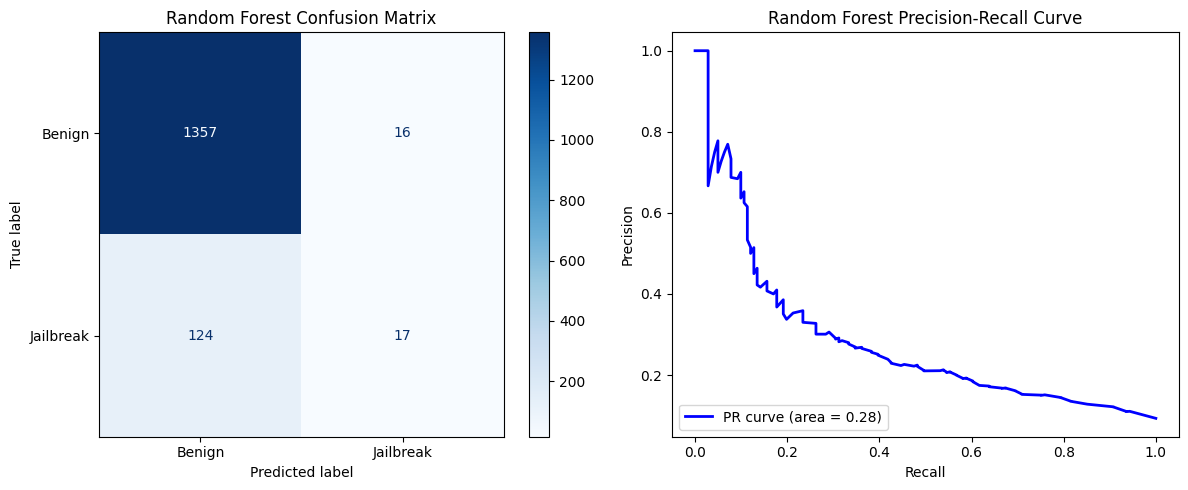

                    Feature  Importance
1         scaled_char_count    0.350906
0         scaled_word_count    0.301325
4  scaled_punctuation_count    0.251440
2  scaled_exclamation_count    0.051675
3     scaled_question_count    0.044654


In [ ]:
# Features: 'scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'
# Parameters: n_estimators = 100

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']],
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']],
])

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(train_features, train_df['jailbreak'])

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: scaled_word_count, scaled_char_count, scaled_exclamation_count, scaled_question_count, scaled_punctuation_count')

feature_importances(random_forest, ['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'])

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest  0.910172  0.134752  0.218391              0.275344


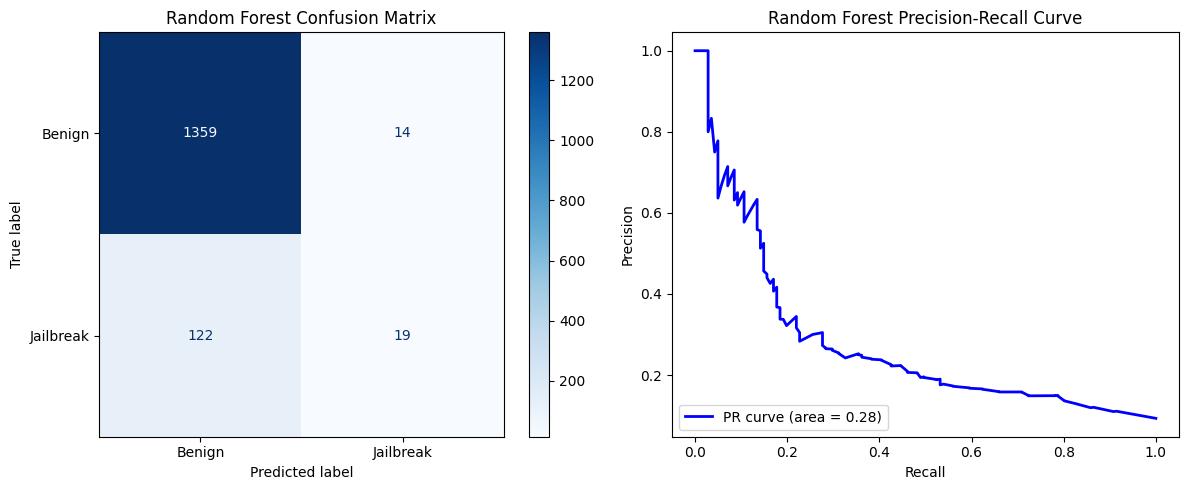

                    Feature  Importance
1         scaled_char_count    0.339595
0         scaled_word_count    0.308278
4  scaled_punctuation_count    0.255906
2  scaled_exclamation_count    0.050762
3     scaled_question_count    0.045458


In [ ]:
# Features: 'scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'
# Parameters: class_weight = 'balanced', n_estimators = 100

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']],
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']],
])

random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
random_forest.fit(train_features, train_df['jailbreak'])

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: scaled_word_count, scaled_char_count, scaled_exclamation_count, scaled_question_count, scaled_punctuation_count; Parameters: class_weight = "balanced", n_estimators = 100')

feature_importances(random_forest, ['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'])

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest  0.931308  0.368794       0.5              0.662751


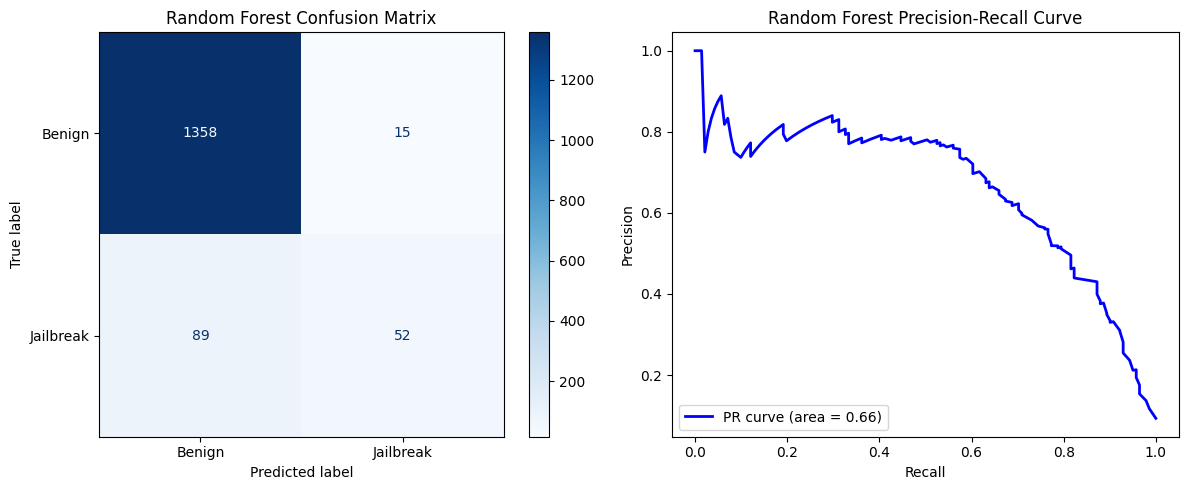

                Feature  Importance
414             chatgpt    0.021021
2338                say    0.019513
2671     targetlanguage    0.017207
1783              never    0.014552
106              always    0.014301
1334            illegal    0.012792
0     scaled_word_count    0.011903
1     scaled_char_count    0.011360
2263           response    0.009507
1840             openai    0.009474


In [ ]:
# Features: TF-IDF, 'scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'
# Parameters: class_weight='balanced', n_estimators = 100

# Loaded TF-IDF features have parameter max_features = 3000

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']].values,
    tfidf_train,
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']].values,
    tfidf_val,
])

random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
random_forest.fit(train_features, train_df['jailbreak'])

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, scaled_word_count, scaled_char_count, scaled_exclamation_count, scaled_question_count, scaled_punctuation_count; Parameters: class_weight = "balanced", n_estimators = 100')

feature_importances(random_forest, ['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'] + tfidf_feature_names.tolist(), top_n=10)

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest  0.931968  0.390071  0.516432               0.63932


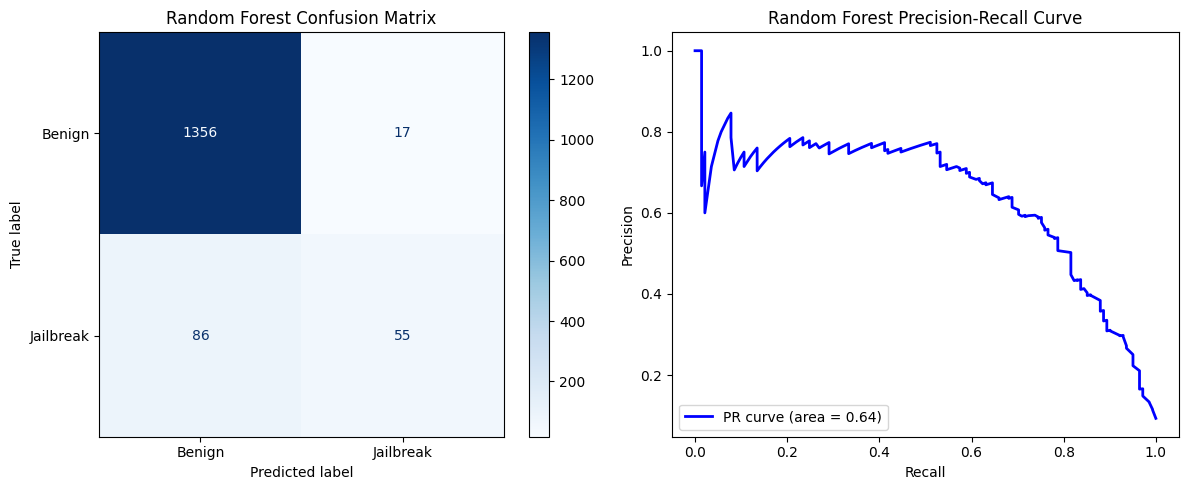

             Feature  Importance
2666  targetlanguage    0.022633
409          chatgpt    0.018831
1778           never    0.014822
1835          openai    0.014218
2333             say    0.013609
136         anything    0.012130
1724           moral    0.011935
2258        response    0.011678
101           always    0.011501
131           answer    0.010400


In [ ]:
# Features: TF-IDF
# Parameters: class_weight='balanced', n_estimators = 100

train_features = tfidf_train

val_features = tfidf_val

random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
random_forest.fit(train_features, train_df['jailbreak'])

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF; Parameters: class_weight = "balanced", n_estimators = 100')

feature_importances(random_forest, tfidf_feature_names.tolist(), top_n=10)

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest   0.93395  0.439716  0.553571              0.642955


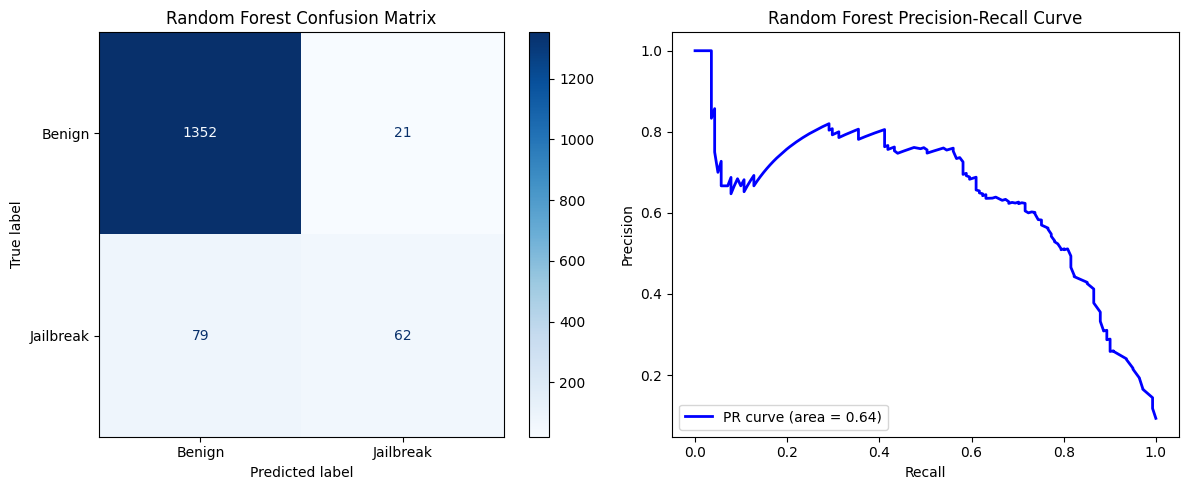

           Feature  Importance
3012  embedding_13    0.023526
3096  embedding_97    0.019531
3050  embedding_51    0.018858
3095  embedding_96    0.018257
3019  embedding_20    0.018193
3077  embedding_78    0.016878
3043  embedding_44    0.016165
3047  embedding_48    0.014843
3065  embedding_66    0.014401
3089  embedding_90    0.012595


In [ ]:
# Features: TF-IDF, Word2Vec
# Parameters: class_weight='balanced', n_estimators = 100

train_features = np.hstack([
    tfidf_train,
    word2vec_train
])

val_features = np.hstack([
    tfidf_val,
    word2vec_val
])

random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
random_forest.fit(train_features, train_df['jailbreak'])

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, Word2Vec; Parameters: class_weight = "balanced", n_estimators = 100')

feature_importances(random_forest, tfidf_feature_names.tolist() + word2vec_feature_names, top_n=10)

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest  0.937252  0.460993  0.577778              0.665852


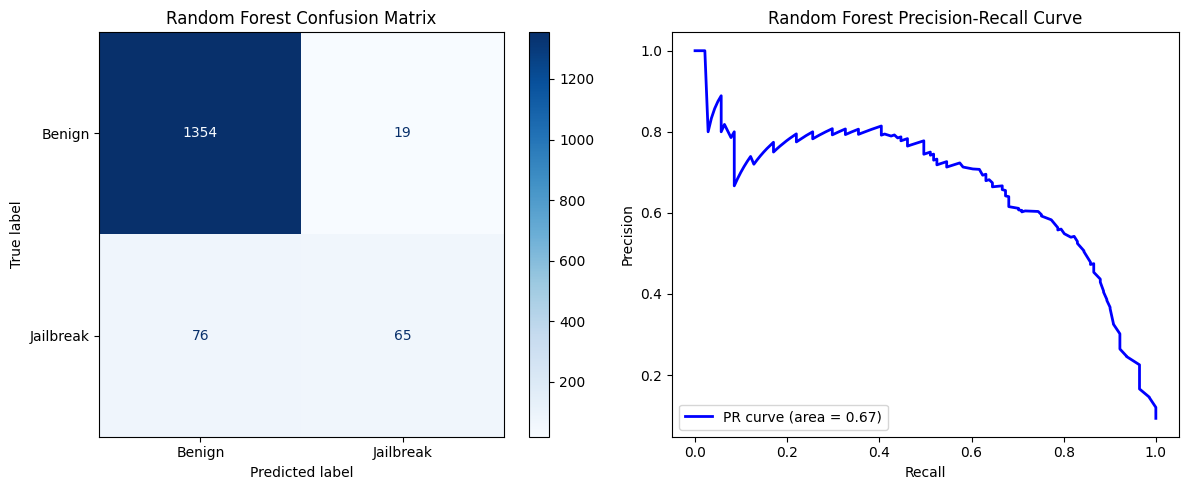

           Feature  Importance
3097  embedding_96    0.026368
3021  embedding_20    0.019734
3030  embedding_29    0.017626
3038  embedding_37    0.016081
3067  embedding_66    0.016013
3079  embedding_78    0.015858
3091  embedding_90    0.014628
3090  embedding_89    0.014092
3096  embedding_95    0.014036
3098  embedding_97    0.013526


In [ ]:
# Features: word_count, char_count, TF-IDF, Word2Vec
# Parameters: class_weight='balanced', n_estimators = 100

train_features = np.hstack([
    train_df[['word_count', 'char_count']].values,
    tfidf_train,
    word2vec_train
])

val_features = np.hstack([
    val_df[['word_count', 'char_count']].values,
    tfidf_val,
    word2vec_val
])

random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
random_forest.fit(train_features, train_df['jailbreak'])

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: word_count, char_count, TF-IDF, Word2Vec; Parameters: class_weight = "balanced", n_estimators = 100')

feature_importances(random_forest, ['word_count', 'char_count'] + tfidf_feature_names.tolist() + word2vec_feature_names, top_n=10)

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest  0.931968  0.446809  0.550218              0.647549


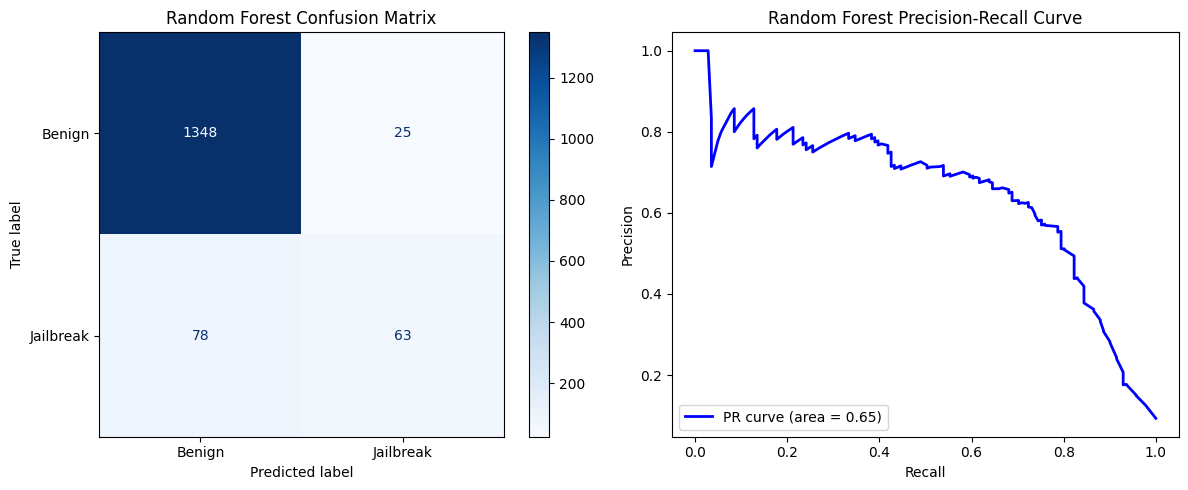

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
         Feature  Importance
97  embedding_96    0.060941
98  embedding_97    0.041992
14  embedding_13    0.038460
79  embedding_78    0.038023
52  embedding_51    0.035465
21  embedding_20    0.034811
95  embedding_94    0.025786
49  embedding_48    0.025232
40  embedding_39    0.025127
54  embedding_53    0.024233


In [ ]:
# Features: word_count, char_count, Word2Vec
# Parameters: class_weight='balanced', n_estimators = 100

train_features = np.hstack([
    train_df[['word_count', 'char_count']].values,
    word2vec_train
])

val_features = np.hstack([
    val_df[['word_count', 'char_count']].values,
    word2vec_val
])

random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
random_forest.fit(train_features, train_df['jailbreak'])

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: word_count, char_count, Word2Vec; Parameters: class_weight = "balanced", n_estimators = 100')

feature_importances(random_forest, ['word_count', 'char_count'] + word2vec_feature_names, top_n=10)

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest   0.93395  0.695035  0.662162              0.631515


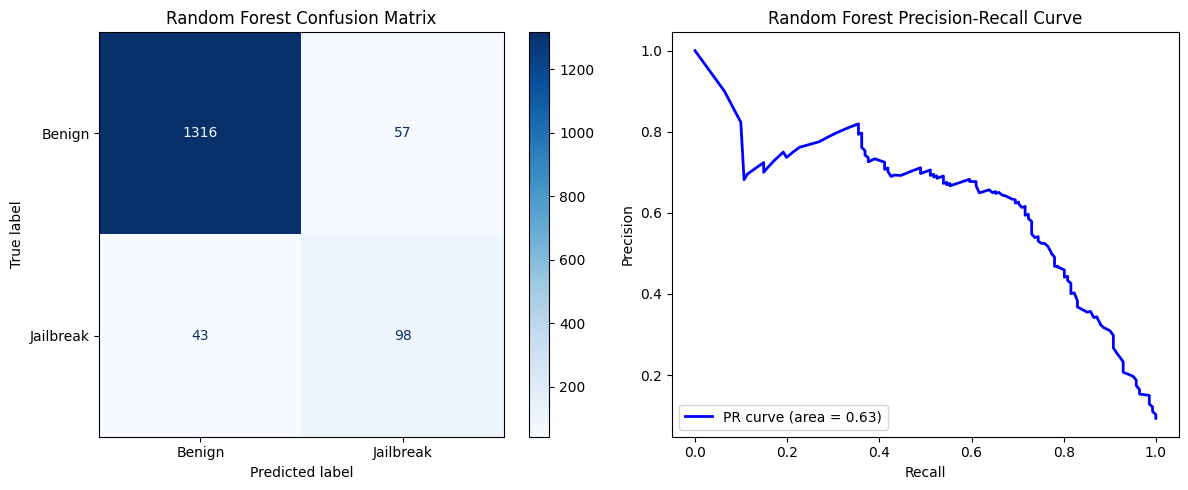

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
          Feature  Importance
95   embedding_96    0.070102
77   embedding_78    0.051359
19   embedding_20    0.035312
96   embedding_97    0.035114
50   embedding_51    0.031703
93   embedding_94    0.027567
2     embedding_3    0.027259
12   embedding_13    0.026279
99  embedding_100    0.021626
31   embedding_32    0.020141


In [ ]:
# Features: Word2Vec (Smote and Tomek Links applied)
# Parameters: n_estimators = 100

train_features = np.hstack([
    word2vec_smote_tomek_embeddings
])

val_features = np.hstack([
    word2vec_val
])

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(train_features, word2vec_smote_tomek_labels)

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: Word2Vec (Smote Tomek); Parameters: n_estimators = 100')

feature_importances(random_forest, word2vec_feature_names, top_n=10)

=== Random Forest Classification Report ===
           Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Random Forest  0.932629  0.460993  0.560345              0.647731


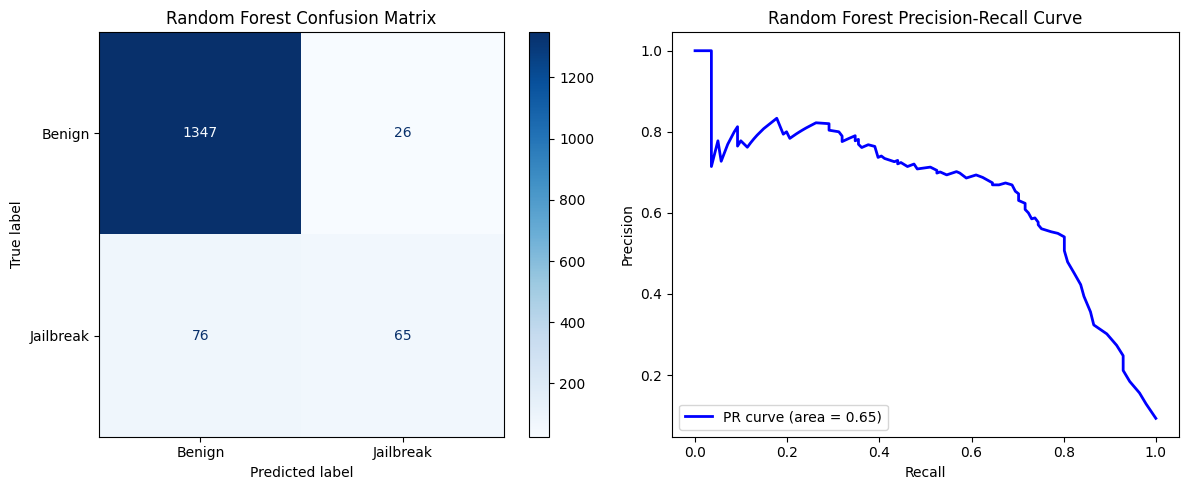

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
          Feature  Importance
120      topic_19    0.084748
97   embedding_96    0.066964
98   embedding_97    0.041731
79   embedding_78    0.037268
4     embedding_3    0.027281
14   embedding_13    0.026021
52   embedding_51    0.023630
54   embedding_53    0.018099
21   embedding_20    0.018038
49   embedding_48    0.016885


In [ ]:
# Features: word_count, char_count, Word2Vec, LDA
# Parameters: class_weight='balanced', n_estimators = 100

train_features = np.hstack([
    train_df[['word_count', 'char_count']].values,
    word2vec_train,
    lda_train
])

val_features = np.hstack([
    val_df[['word_count', 'char_count']].values,
    word2vec_val,
    lda_val
])

random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
random_forest.fit(train_features, train_df['jailbreak'])

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: word_count, char_count, Word2Vec, LDA; Parameters: class_weight = "balanced", n_estimators = 100')

feature_importances(random_forest, ['word_count', 'char_count'] + word2vec_feature_names + lda_feature_names, top_n=10)

Random forest appears to get low recall with parameter class_weight='balanced.' Performace is best instead using Word2Vec embeddings resampled with Smote and Tomek Links method. Below, I will do hyperparameter tuning for this model.

In [ ]:
# Hyperparameter tuning Random Forest

train_features = word2vec_smote_tomek_embeddings

val_features = word2vec_val

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(train_features, word2vec_smote_tomek_labels)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

random_forest = RandomForestClassifier(**best_params, random_state=42)
random_forest.fit(train_features, word2vec_smote_tomek_labels)

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Random Forest', y_pred_prob, val_df['jailbreak'])
# save_metrics(results, 'Features: Word2Vec (Smote Tomek); Parameters: n_estimators = 100')

feature_importances(random_forest, word2vec_feature_names, top_n=10)

Best hyperparameters were n_estimators = 100 and max_depth = 10. Below, I test various probability thresholds for the random forest model.

In [ ]:
train_features = word2vec_smote_tomek_embeddings
val_features = word2vec_val

random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
random_forest.fit(train_features, word2vec_smote_tomek_labels)

y_pred_prob = random_forest.predict_proba(val_features)[:, 1]

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for threshold in thresholds:
  results, fig = evaluation_metrics(f'Random Forest (threshold={threshold})', y_pred_prob, val_df['jailbreak'], threshold=threshold, plots=False)

=== Random Forest (threshold=0.2) Classification Report ===
                           Model  Accuracy    Recall  F1-Score  \
0  Random Forest (threshold=0.2)  0.721929  0.914894  0.379971   

   Precision-Recall AUC  
0              0.629819  
=== Random Forest (threshold=0.25) Classification Report ===
                            Model  Accuracy    Recall  F1-Score  \
0  Random Forest (threshold=0.25)  0.770145  0.900709  0.421927   

   Precision-Recall AUC  
0              0.629819  
=== Random Forest (threshold=0.3) Classification Report ===
                           Model  Accuracy   Recall  F1-Score  \
0  Random Forest (threshold=0.3)  0.817041  0.87234  0.470363   

   Precision-Recall AUC  
0              0.629819  
=== Random Forest (threshold=0.35) Classification Report ===
                            Model  Accuracy    Recall  F1-Score  \
0  Random Forest (threshold=0.35)  0.846764  0.851064  0.508475   

   Precision-Recall AUC  
0              0.629819  
=== Random Fores

I select a threshold of 0.3, which achieves a validation accuracy of 0.82 and validation recall of 0.87.